In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [18]:
train_data1 = pd.read_csv('train_ver_2.csv')



# Train 데이터를 Train과 Validation 세트로 나누기
X_train1, X_val1, y_train1, y_val1 = train_test_split(train_data1.drop(columns=['Response']),
                                                  train_data1['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data1['Response'],
                                                  random_state = 31)
test_data1 = pd.read_csv('test_ver_2.csv')

In [19]:
adf = 123

In [22]:
# Train 데이터 불러오기
train_data1 = pd.read_csv('train_ver_2.csv')

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in train_data1.columns if col not in ['Education', 'Marital_Status', 'Response']]

# standard scaler
std_scale = MinMaxScaler()
#X_tn_std = std_scale.fit_transform(X_train[numeric_cols])
#X_te_std = std_scale.transform(X_val[numeric_cols])
train_data_std = std_scale.fit_transform(train_data1[numeric_cols])

# onehot encoder
oh_encod = OneHotEncoder(sparse_output=False)
#X_tn_enc_cat = oh_encod.fit_transform(X_train[categorical_cols])
#X_te_enc_cat = oh_encod.transform(X_val[categorical_cols])
train_data_enc = oh_encod.fit_transform(train_data1[categorical_cols])

# process dataset 
processed_data = np.hstack((train_data_std, train_data_enc))
y_train = train_data1['Response']
#valid_data = np.hstack((X_te_std, X_te_enc_cat))

# auc 기준 최적화 함수 작성
def logistic_regression_cv1(C, solver, penalty, max_iter, tol):
    C = 10 ** C  # 로그 스케일 C 변환
    max_iter = int(max_iter)
    tol = 10 ** tol  # 로그 스케일 tol 변환
    penalty_options = ['l1', 'l2', None]  # 'none' 옵션 추가
    solver_options = ['liblinear', 'saga']

    # 범주형 매개변수 매핑
    penalty = penalty_options[int(penalty)]
    solver = solver_options[int(solver)]
    if penalty is None and solver not in ['lbfgs', 'newton-cg', 'sag', 'saga']:
        return 0 # 'None' 규제는 'liblinear'와 호환되지 않음

    # 모델 생성
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter, tol=tol, random_state=42)
    
    #cross_val_score를 사용하여 교차 검증을 수행, scoring을 'auc'으로 설정
    scores1 = cross_val_score(model, processed_data, y_train, cv=3, scoring='roc_auc')
    
    
    # 평균 점수 반환
    return scores1.mean()

# f1-score 기준 기준 최적화 함수 작성
def logistic_regression_cv2(C, solver, penalty, max_iter, tol):
    C = 10 ** C  # 로그 스케일 C 변환
    max_iter = int(max_iter)
    tol = 10 ** tol  # 로그 스케일 tol 변환
    penalty_options = ['l1', 'l2', None]  # 'none' 옵션 추가
    solver_options = ['liblinear', 'saga']

    # 범주형 매개변수 매핑
    penalty = penalty_options[int(penalty)]
    solver = solver_options[int(solver)]
    if penalty is None and solver not in ['lbfgs', 'newton-cg', 'sag', 'saga']:
        return 0 # 'None' 규제는 'liblinear'와 호환되지 않음

    # 모델 생성
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter, tol=tol, random_state=42)
    
    #cross_val_score를 사용하여 교차 검증을 수행, scoring을 'f1'으로 설정
    scores2 = cross_val_score(model, processed_data, y_train, cv=3, scoring='f1')
    
    
    # 평균 점수 반환
    return scores2.mean()


def logistic_regression_cv3(C, solver, penalty, max_iter, tol):
    C = 10 ** C  # 로그 스케일 C 변환
    max_iter = int(max_iter)
    tol = 10 ** tol  # 로그 스케일 tol 변환
    penalty_options = ['l1', 'l2', None]  # 'none' 옵션 추가
    solver_options = ['liblinear', 'saga']

    # 범주형 매개변수 매핑
    penalty = penalty_options[int(penalty)]
    solver = solver_options[int(solver)]
    if penalty is None and solver not in ['lbfgs', 'newton-cg', 'sag', 'saga']:
        return 0 # 'None' 규제는 'liblinear'와 호환되지 않음

    # 모델 생성
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter, tol=tol, random_state=42)
    
    # f1 score 계산
    f1_scores = cross_val_score(model, processed_data, y_train, cv=3, scoring='f1')
    f1_score_mean = f1_scores.mean()
    
    # AUC 계산
    auc_scores = cross_val_score(model, processed_data, y_train, cv=3, scoring='roc_auc')
    auc_score_mean = auc_scores.mean()
    
    # 예를 들어, 각 점수를 동등하게 취급하려면:
    combined_score = (f1_score_mean + auc_score_mean) / 2

    return combined_score

# 베이지안 최적화의 파라미터 공간 정의
params = {
    'C': (-6, 6),  # 로그 스케일로 C 파라미터 탐색
    'solver': (0, 1),  # 0 = 'liblinear', 1 = 'saga'
    'penalty': (0, 2),  # 0 = 'l1', 1 = 'l2', 2 = 'none'
    'max_iter': (10, 500),  # 정수 범위
    'tol': (-6, -1)  # 로그 스케일로 tol 파라미터 탐색
}

# BayesianOptimization 객체 생성
optimizer1 = BayesianOptimization(
    f=logistic_regression_cv1,  # 최적화할 함수
    pbounds=params,            # 파라미터 범위
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer1.maximize(
    init_points=5,   # 랜덤하게 탐색할 초기 포인트 수
    n_iter=25,       # 베이지안 최적화를 통해 탐색할 포인트 수
)
# BayesianOptimization 객체 생성
optimizer2 = BayesianOptimization(
    f=logistic_regression_cv2,  # 최적화할 함수
    pbounds=params,            # 파라미터 범위
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer2.maximize(
    init_points=5,   # 랜덤하게 탐색할 초기 포인트 수
    n_iter=25,       # 베이지안 최적화를 통해 탐색할 포인트 수
)
# BayesianOptimization 객체 생성
optimizer3 = BayesianOptimization(
    f=logistic_regression_cv3,  # 최적화할 함수
    pbounds=params,            # 파라미터 범위
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer3.maximize(
    init_points=5,   # 랜덤하게 탐색할 초기 포인트 수
    n_iter=25,       # 베이지안 최적화를 통해 탐색할 포인트 수
)


# 파라미터 정리
penalty_options = ['l1', 'l2', None]
solver_options = ['liblinear', 'saga']

# auc 파라미터
best_auc_C = 10 ** optimizer1.max['params']['C']
best_auc_max_iter = int(round(optimizer1.max['params']['max_iter']))  # 반올림 후 정수 변환
best_auc_penalty_index = int(round(optimizer1.max['params']['penalty']))  # 반올림 후 인덱스 변환
best_auc_penalty = penalty_options[best_auc_penalty_index]
best_auc_solver_index = int(round(optimizer1.max['params']['solver']))  # 반올림 후 인덱스 변환
best_auc_solver = solver_options[best_auc_solver_index]
best_auc_tol = 10 ** -optimizer1.max['params']['tol']  

# f1 파라미터
best_f1_C = 10 ** optimizer2.max['params']['C']
best_f1_max_iter = int(round(optimizer2.max['params']['max_iter']))  # 반올림 후 정수 변환
best_f1_penalty_index = int(round(optimizer2.max['params']['penalty']))  # 반올림 후 인덱스 변환
best_f1_penalty = penalty_options[best_f1_penalty_index]
best_f1_solver_index = int(round(optimizer2.max['params']['solver']))  # 반올림 후 인덱스 변환
best_f1_solver = solver_options[best_f1_solver_index]
best_f1_tol = 10 ** -optimizer2.max['params']['tol']  

# 통합 파라미터
best_all_C = 10 ** optimizer3.max['params']['C']
best_all_max_iter = int(round(optimizer3.max['params']['max_iter']))  # 반올림 후 정수 변환
best_all_penalty_index = int(round(optimizer3.max['params']['penalty']))  # 반올림 후 인덱스 변환
best_all_penalty = penalty_options[best_all_penalty_index]
best_all_solver_index = int(round(optimizer3.max['params']['solver']))  # 반올림 후 인덱스 변환
best_all_solver = solver_options[best_all_solver_index]
best_all_tol = 10 ** -optimizer3.max['params']['tol']  

best_auc = {
    'C': best_auc_C,
    'max_iter': best_auc_max_iter,
    'penalty': best_auc_penalty,
    'solver': best_auc_solver,
    'tol': best_auc_tol
}

best_f1 = {
    'C': best_f1_C,
    'max_iter': best_f1_max_iter,
    'penalty': best_f1_penalty,
    'solver': best_f1_solver,
    'tol': best_f1_tol
}

best_all = {
    'C': best_all_C,
    'max_iter': best_all_max_iter,
    'penalty': best_all_penalty,
    'solver': best_all_solver,
    'tol': best_all_tol
}

|   iter    |  target   |     C     | max_iter  |  penalty  |  solver   |    tol    |
-------------------------------------------------------------------------------------
| 1         | 0.7752    | -1.506    | 475.9     | 1.464     | 0.5987    | -5.22     |
| 2         | 0.5473    | -4.128    | 38.46     | 1.732     | 0.6011    | -2.46     |
| 3         | 0.5444    | -5.753    | 485.3     | 1.665     | 0.2123    | -5.091    |
| 4         | 0.5506    | -3.799    | 159.1     | 1.05      | 0.4319    | -4.544    |
| 5         | 0.8503    | 1.342     | 78.35     | 0.5843    | 0.3664    | -3.72     |
| 6         | 0.7923    | -1.291    | 476.4     | 1.851     | 0.6605    | -5.956    |
| 7         | 0.8462    | 2.219     | 84.4      | 0.8015    | 0.3268    | -3.278    |
| 8         | 0.5       | -6.0      | 82.63     | 0.0       | 1.0       | -6.0      |
| 9         | 0.8511    | 5.925     | 80.58     | 1.059     | 0.0       | -2.17     |
| 10        | 0.8477    | 4.832     | 72.77     | 2.0 

| 27        | 0.0       | -1.636    | 134.5     | 0.4558    | 0.7771    | -1.24     |
| 28        | 0.0       | -2.35     | 113.9     | 0.7021    | 0.6364    | -5.576    |
| 29        | 0.0       | -0.1216   | 316.0     | 2.0       | 0.0       | -1.0      |
| 30        | 0.396     | 1.841     | 74.42     | 1.207     | 1.0       | -1.0      |
|   iter    |  target   |     C     | max_iter  |  penalty  |  solver   |    tol    |
-------------------------------------------------------------------------------------
| 1         | 0.3876    | -1.506    | 475.9     | 1.464     | 0.5987    | -5.22     |
| 2         | 0.2737    | -4.128    | 38.46     | 1.732     | 0.6011    | -2.46     |
| 3         | 0.2722    | -5.753    | 485.3     | 1.665     | 0.2123    | -5.091    |
| 4         | 0.2753    | -3.799    | 159.1     | 1.05      | 0.4319    | -4.544    |
| 5         | 0.6317    | 1.342     | 78.35     | 0.5843    | 0.3664    | -3.72     |
| 6         | 0.4073    | -1.291    | 476.4     | 1.85

F1-Score on Test Data: 0.23529411764705882
AUC on Test Data: 0.8324669568020632


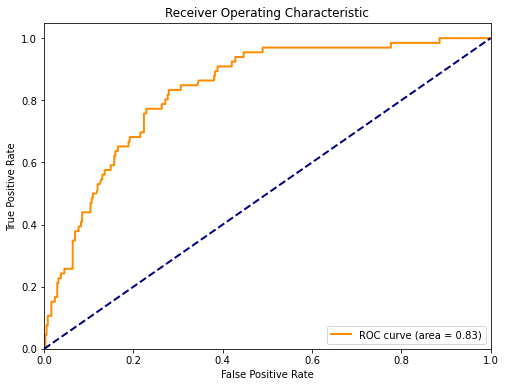

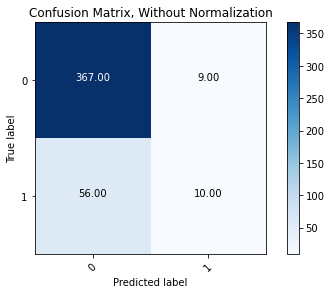

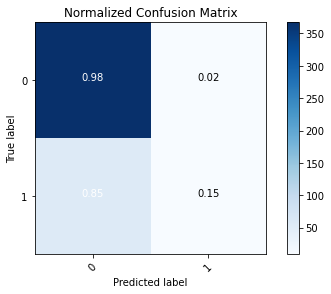

array([[367,   9],
       [ 56,  10]], dtype=int64)

In [5]:
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in test_data1.columns if col not in ['Education', 'Marital_Status', 'Response']]

test_scale = std_scale.transform(test_data1[numeric_cols])
test_encod = oh_encod.transform(test_data1[categorical_cols])

test_processed_data = np.hstack((test_scale, test_encod))
y_test = test_data1['Response']

# test 데이터 적용
model_auc = LogisticRegression(
    C=best_auc['C'],
    penalty=best_auc['penalty'],
    solver='saga',
    max_iter=best_auc['max_iter'],
    tol=best_auc['tol'],
    random_state=42
)
model_auc.fit(processed_data, y_train)
y_auc_pred = model_auc.predict(test_processed_data)
y_pred_proba = model_auc.predict_proba(test_processed_data)[:, 1]

f1 = f1_score(y_test, y_auc_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1-Score on Test Data: {f1}")
print(f"AUC on Test Data: {auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, model_auc.predict(test_processed_data))

def plot_conf_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['0', '1']

# 시각화 실행
plot_conf_matrix(cm, classes=class_names,
                 title='Confusion Matrix, Without Normalization')

# 정규화된 혼동 행렬 시각화도 가능
plt.figure()
plot_conf_matrix(cm, classes=class_names, normalize=True,
                 title='Normalized Confusion Matrix')

plt.show()
cm

F1-Score on Test Data: 0.0
AUC on Test Data: 0.5


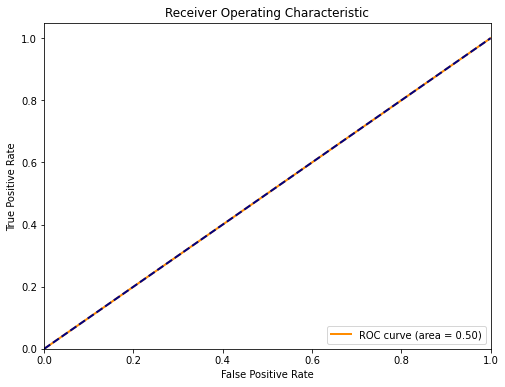

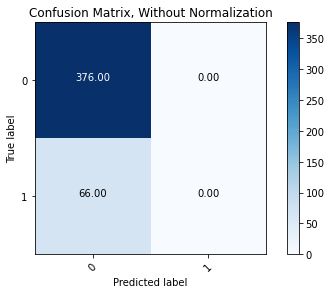

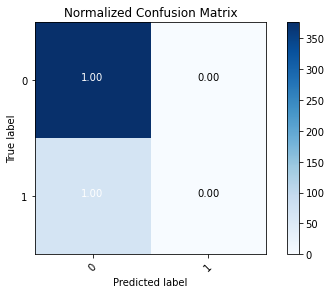

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       376
           1       0.00      0.00      0.00        66

    accuracy                           0.85       442
   macro avg       0.43      0.50      0.46       442
weighted avg       0.72      0.85      0.78       442



In [24]:
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in train_data1.columns if col not in ['Education', 'Marital_Status', 'Response']]

test_scale = std_scale.transform(test_data1[numeric_cols])
test_encod = oh_encod.transform(test_data1[categorical_cols])

test_processed_data = np.hstack((test_scale, test_encod))
y_test = test_data1['Response']

# test 데이터 적용
model_f1 = LogisticRegression(
    C=best_f1['C'],
    penalty=best_f1['penalty'],
    solver=best_f1['solver'],
    max_iter=best_f1['max_iter'],
    tol=best_f1['tol'],
    random_state=42
)
model_f1.fit(processed_data, y_train)
y_auc_pred = model_f1.predict(test_processed_data)
y_pred_proba = model_f1.predict_proba(test_processed_data)[:, 1]

f1 = f1_score(y_test, y_auc_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1-Score on Test Data: {f1}")
print(f"AUC on Test Data: {auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, model_f1.predict(test_processed_data))

def plot_conf_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['0', '1']

# 시각화 실행
plot_conf_matrix(cm, classes=class_names,
                 title='Confusion Matrix, Without Normalization')

# 정규화된 혼동 행렬 시각화도 가능
plt.figure()
plot_conf_matrix(cm, classes=class_names, normalize=True,
                 title='Normalized Confusion Matrix')

plt.show()
cm
from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(y_test, y_auc_pred, 
                            target_names=target_names))


F1-Score on Test Data: 0.23529411764705882
AUC on Test Data: 0.8324669568020632


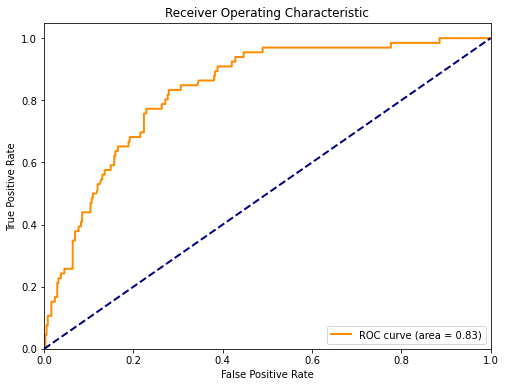

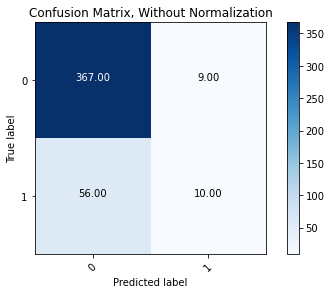

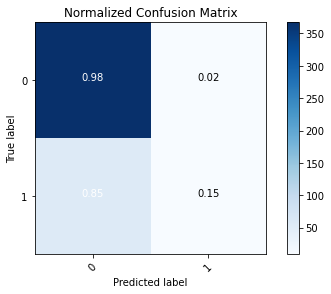

array([[367,   9],
       [ 56,  10]], dtype=int64)

In [7]:
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in train_data1.columns if col not in ['Education', 'Marital_Status', 'Response']]

test_scale = std_scale.transform(test_data1[numeric_cols])
test_encod = oh_encod.transform(test_data1[categorical_cols])

test_processed_data = np.hstack((test_scale, test_encod))
y_test = test_data1['Response']

# test 데이터 적용
model_auc = LogisticRegression(
    C=best_auc['C'],
    penalty=best_auc['penalty'],
    solver='saga',
    max_iter=best_auc['max_iter'],
    tol=best_auc['tol'],
    random_state=42
)
model_auc.fit(processed_data, y_train)
y_auc_pred = model_auc.predict(test_processed_data)
y_pred_proba = model_auc.predict_proba(test_processed_data)[:, 1]

f1 = f1_score(y_test, y_auc_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1-Score on Test Data: {f1}")
print(f"AUC on Test Data: {auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, model_auc.predict(test_processed_data))

def plot_conf_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['0', '1']

# 시각화 실행
plot_conf_matrix(cm, classes=class_names,
                 title='Confusion Matrix, Without Normalization')

# 정규화된 혼동 행렬 시각화도 가능
plt.figure()
plot_conf_matrix(cm, classes=class_names, normalize=True,
                 title='Normalized Confusion Matrix')

plt.show()
cm

F1-Score on Test Data: 0.23529411764705882
AUC on Test Data: 0.8324669568020632


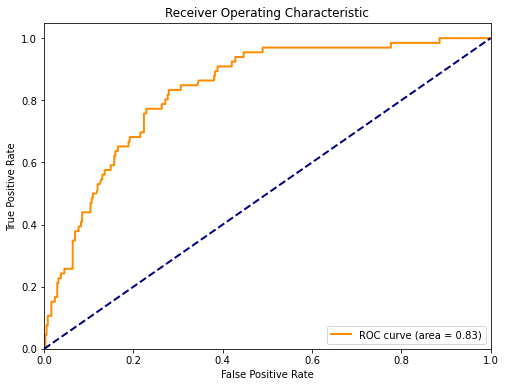

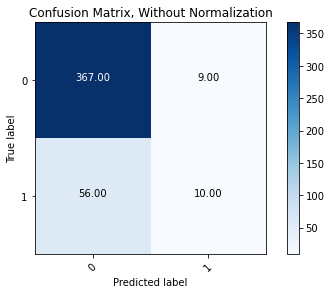

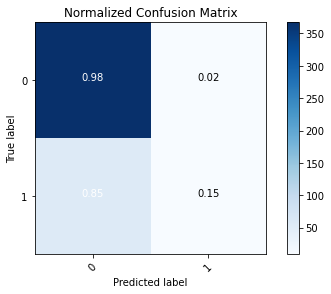

array([[367,   9],
       [ 56,  10]], dtype=int64)

In [8]:
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in train_data1.columns if col not in ['Education', 'Marital_Status', 'Response']]

test_scale = std_scale.transform(test_data1[numeric_cols])
test_encod = oh_encod.transform(test_data1[categorical_cols])

test_processed_data = np.hstack((test_scale, test_encod))
y_test = test_data1['Response']

# test 데이터 적용
model_all = LogisticRegression(
    C=best_all['C'],
    penalty=best_all['penalty'],
    solver=best_all['solver'],
    max_iter=best_all['max_iter'],
    tol=best_all['tol'],
    random_state=42
)
model_all.fit(processed_data, y_train)
y_auc_pred = model_all.predict(test_processed_data)
y_pred_proba = model_all.predict_proba(test_processed_data)[:, 1]

f1 = f1_score(y_test, y_auc_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1-Score on Test Data: {f1}")
print(f"AUC on Test Data: {auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, model_all.predict(test_processed_data))

def plot_conf_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['0', '1']

# 시각화 실행
plot_conf_matrix(cm, classes=class_names,
                 title='Confusion Matrix, Without Normalization')

# 정규화된 혼동 행렬 시각화도 가능
plt.figure()
plot_conf_matrix(cm, classes=class_names, normalize=True,
                 title='Normalized Confusion Matrix')

plt.show()
cm

In [9]:
# Train 데이터 불러오기
train_data1 = pd.read_csv('train_ver_2.csv')

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in train_data1.columns if col not in ['Education', 'Marital_Status', 'Response']]

# standard scaler
std_scale = MinMaxScaler()
#X_tn_std = std_scale.fit_transform(X_train[numeric_cols])
#X_te_std = std_scale.transform(X_val[numeric_cols])
train_data_std = std_scale.fit_transform(train_data1[numeric_cols])

# onehot encoder
oh_encod = OneHotEncoder(sparse_output=False)
#X_tn_enc_cat = oh_encod.fit_transform(X_train[categorical_cols])
#X_te_enc_cat = oh_encod.transform(X_val[categorical_cols])
train_data_enc = oh_encod.fit_transform(train_data1[categorical_cols])

# process dataset 
processed_data = np.hstack((train_data_std, train_data_enc))
y_train = train_data1['Response']
#valid_data = np.hstack((X_te_std, X_te_enc_cat))

# auc 기준 최적화 함수 작성
def logistic_regression_cv1(C, solver, penalty, max_iter, tol):
    C = 10 ** C  # 로그 스케일 C 변환
    max_iter = int(max_iter)
    tol = 10 ** tol  # 로그 스케일 tol 변환
    penalty_options = ['l1', 'l2', None]  # 'none' 옵션 추가
    solver_options = ['liblinear', 'saga']

    # 범주형 매개변수 매핑
    penalty = penalty_options[int(penalty)]
    solver = solver_options[int(solver)]
    if penalty is None and solver not in ['lbfgs', 'newton-cg', 'sag', 'saga']:
        return 0 # 'None' 규제는 'liblinear'와 호환되지 않음

    # 모델 생성
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter, tol=tol, random_state=42)
    
    #cross_val_score를 사용하여 교차 검증을 수행, scoring을 'auc'으로 설정
    scores1 = cross_val_score(model, processed_data, y_train, cv=3, scoring='roc_auc')
    
    
    # 평균 점수 반환
    return scores1.mean()

# f1-score 기준 기준 최적화 함수 작성
def logistic_regression_cv2(C, solver, penalty, max_iter, tol):
    C = 10 ** C  # 로그 스케일 C 변환
    max_iter = int(max_iter)
    tol = 10 ** tol  # 로그 스케일 tol 변환
    penalty_options = ['l1', 'l2', None]  # 'none' 옵션 추가
    solver_options = ['liblinear', 'saga']

    # 범주형 매개변수 매핑
    penalty = penalty_options[int(penalty)]
    solver = solver_options[int(solver)]
    if penalty is None and solver not in ['lbfgs', 'newton-cg', 'sag', 'saga']:
        return 0 # 'None' 규제는 'liblinear'와 호환되지 않음

    # 모델 생성
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter, tol=tol, random_state=42)
    
    #cross_val_score를 사용하여 교차 검증을 수행, scoring을 'f1'으로 설정
    scores2 = cross_val_score(model, processed_data, y_train, cv=3, scoring='f1')
    
    
    # 평균 점수 반환
    return scores2.mean()


def logistic_regression_cv3(C, solver, penalty, max_iter, tol):
    C = 10 ** C  # 로그 스케일 C 변환
    max_iter = int(max_iter)
    tol = 10 ** tol  # 로그 스케일 tol 변환
    penalty_options = ['l1', 'l2', None]  # 'none' 옵션 추가
    solver_options = ['liblinear', 'saga']

    # 범주형 매개변수 매핑
    penalty = penalty_options[int(penalty)]
    solver = solver_options[int(solver)]
    if penalty is None and solver not in ['lbfgs', 'newton-cg', 'sag', 'saga']:
        return 0 # 'None' 규제는 'liblinear'와 호환되지 않음

    # 모델 생성
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter, tol=tol, random_state=42)
    
    # f1 score 계산
    f1_scores = cross_val_score(model, processed_data, y_train, cv=3, scoring='f1')
    f1_score_mean = f1_scores.mean()
    
    # AUC 계산
    auc_scores = cross_val_score(model, processed_data, y_train, cv=3, scoring='roc_auc')
    auc_score_mean = auc_scores.mean()
    
    # 예를 들어, 각 점수를 동등하게 취급하려면:
    combined_score = (f1_score_mean + auc_score_mean) / 2

    return combined_score

# 베이지안 최적화의 파라미터 공간 정의
params = {
    'C': (-6, 6),  # 로그 스케일로 C 파라미터 탐색
    'solver': (0, 1),  # 0 = 'liblinear', 1 = 'saga'
    'penalty': (0, 2),  # 0 = 'l1', 1 = 'l2', 2 = 'none'
    'max_iter': (10, 500),  # 정수 범위
    'tol': (-6, -1)  # 로그 스케일로 tol 파라미터 탐색
}

# BayesianOptimization 객체 생성
optimizer1 = BayesianOptimization(
    f=logistic_regression_cv1,  # 최적화할 함수
    pbounds=params,            # 파라미터 범위
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer1.maximize(
    init_points=5,   # 랜덤하게 탐색할 초기 포인트 수
    n_iter=25,       # 베이지안 최적화를 통해 탐색할 포인트 수
)
# BayesianOptimization 객체 생성
optimizer2 = BayesianOptimization(
    f=logistic_regression_cv2,  # 최적화할 함수
    pbounds=params,            # 파라미터 범위
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer2.maximize(
    init_points=5,   # 랜덤하게 탐색할 초기 포인트 수
    n_iter=25,       # 베이지안 최적화를 통해 탐색할 포인트 수
)
# BayesianOptimization 객체 생성
optimizer3 = BayesianOptimization(
    f=logistic_regression_cv3,  # 최적화할 함수
    pbounds=params,            # 파라미터 범위
    random_state=42,
    verbose=2
)

# 최적화 수행
optimizer3.maximize(
    init_points=5,   # 랜덤하게 탐색할 초기 포인트 수
    n_iter=25,       # 베이지안 최적화를 통해 탐색할 포인트 수
)


# 파라미터 정리
penalty_options = ['l1', 'l2', None]
solver_options = ['liblinear', 'saga']

# auc 파라미터
best_auc_C = 10 ** optimizer1.max['params']['C']
best_auc_max_iter = int(round(optimizer1.max['params']['max_iter']))  # 반올림 후 정수 변환
best_auc_penalty_index = int(round(optimizer1.max['params']['penalty']))  # 반올림 후 인덱스 변환
best_auc_penalty = penalty_options[best_auc_penalty_index]
best_auc_solver_index = int(round(optimizer1.max['params']['solver']))  # 반올림 후 인덱스 변환
best_auc_solver = solver_options[best_auc_solver_index]
best_auc_tol = 10 ** -optimizer1.max['params']['tol']  

# f1 파라미터
best_f1_C = 10 ** optimizer2.max['params']['C']
best_f1_max_iter = int(round(optimizer2.max['params']['max_iter']))  # 반올림 후 정수 변환
best_f1_penalty_index = int(round(optimizer2.max['params']['penalty']))  # 반올림 후 인덱스 변환
best_f1_penalty = penalty_options[best_f1_penalty_index]
best_f1_solver_index = int(round(optimizer2.max['params']['solver']))  # 반올림 후 인덱스 변환
best_f1_solver = solver_options[best_f1_solver_index]
best_f1_tol = 10 ** -optimizer2.max['params']['tol']  

# 통합 파라미터
best_all_C = 10 ** optimizer3.max['params']['C']
best_all_max_iter = int(round(optimizer3.max['params']['max_iter']))  # 반올림 후 정수 변환
best_all_penalty_index = int(round(optimizer3.max['params']['penalty']))  # 반올림 후 인덱스 변환
best_all_penalty = penalty_options[best_all_penalty_index]
best_all_solver_index = int(round(optimizer3.max['params']['solver']))  # 반올림 후 인덱스 변환
best_all_solver = solver_options[best_all_solver_index]
best_all_tol = 10 ** -optimizer3.max['params']['tol']  

best_auc = {
    'C': best_auc_C,
    'max_iter': best_auc_max_iter,
    'penalty': best_auc_penalty,
    'solver': best_auc_solver,
    'tol': best_auc_tol
}

best_f1 = {
    'C': best_f1_C,
    'max_iter': best_f1_max_iter,
    'penalty': best_f1_penalty,
    'solver': best_f1_solver,
    'tol': best_f1_tol
}

best_all = {
    'C': best_all_C,
    'max_iter': best_all_max_iter,
    'penalty': best_all_penalty,
    'solver': best_all_solver,
    'tol': best_all_tol
}

|   iter    |  target   |     C     | max_iter  |  penalty  |  solver   |    tol    |
-------------------------------------------------------------------------------------
| 1         | 0.7752    | -1.506    | 475.9     | 1.464     | 0.5987    | -5.22     |
| 2         | 0.5473    | -4.128    | 38.46     | 1.732     | 0.6011    | -2.46     |
| 3         | 0.5444    | -5.753    | 485.3     | 1.665     | 0.2123    | -5.091    |
| 4         | 0.5506    | -3.799    | 159.1     | 1.05      | 0.4319    | -4.544    |
| 5         | 0.8503    | 1.342     | 78.35     | 0.5843    | 0.3664    | -3.72     |
| 6         | 0.7923    | -1.291    | 476.4     | 1.851     | 0.6605    | -5.956    |
| 7         | 0.8462    | 2.219     | 84.4      | 0.8015    | 0.3268    | -3.278    |
| 8         | 0.5       | -6.0      | 82.63     | 0.0       | 1.0       | -6.0      |
| 9         | 0.8511    | 5.925     | 80.58     | 1.059     | 0.0       | -2.17     |
| 10        | 0.8477    | 4.832     | 72.77     | 2.0 

| 26        | 0.0       | -6.0      | 244.4     | 2.0       | 0.0       | -1.0      |
| 27        | 0.0       | -1.636    | 134.5     | 0.4558    | 0.7771    | -1.24     |
| 28        | 0.0       | -2.35     | 113.9     | 0.7021    | 0.6364    | -5.576    |
| 29        | 0.0       | -0.1216   | 316.0     | 2.0       | 0.0       | -1.0      |
| 30        | 0.396     | 1.841     | 74.42     | 1.207     | 1.0       | -1.0      |
|   iter    |  target   |     C     | max_iter  |  penalty  |  solver   |    tol    |
-------------------------------------------------------------------------------------
| 1         | 0.3876    | -1.506    | 475.9     | 1.464     | 0.5987    | -5.22     |
| 2         | 0.2737    | -4.128    | 38.46     | 1.732     | 0.6011    | -2.46     |
| 3         | 0.2722    | -5.753    | 485.3     | 1.665     | 0.2123    | -5.091    |
| 4         | 0.2753    | -3.799    | 159.1     | 1.05      | 0.4319    | -4.544    |
| 5         | 0.6317    | 1.342     | 78.35     | 0.58

In [10]:
#  auc 기준 최적의 파라미터와 점수 출력
print("auc Best parameters:", optimizer1.max['params'])
print("auc Best score:", optimizer1.max['target'])
# f1-score 기준 최적의 파라미터와 점수 출력
print("f1 Best parameters:", optimizer2.max['params'])
print("f1 Best score:", optimizer2.max['target'])
# f1-score, auc 평균 기준 최적의 파라미터와 점수 출력
print("all Best parameters:", optimizer3.max['params'])
print("all Best score:", optimizer3.max['target'])

best_auc

auc Best parameters: {'C': 5.971476465260935, 'max_iter': 466.5268352668821, 'penalty': 1.7593656473849377, 'solver': 0.907951057417608, 'tol': -1.5751675397699154}
auc Best score: 0.8513181831773974
f1 Best parameters: {'C': 1.3422347366685532, 'max_iter': 78.3519917195005, 'penalty': 0.5842892970704363, 'solver': 0.3663618432936917, 'tol': -3.71965007891482}
f1 Best score: 0.4130483821485933
all Best parameters: {'C': 5.6341883092068255, 'max_iter': 372.55023875421716, 'penalty': 1.4628382935263813, 'solver': 0.48504115994714436, 'tol': -2.5567370650438317}
all Best score: 0.6340255539163393


{'C': 936432.4725512862,
 'max_iter': 467,
 'penalty': None,
 'solver': 'saga',
 'tol': 37.59824207740263}

F1-Score on Test Data: 0.2558139534883721
AUC on Test Data: 0.8356100902643455


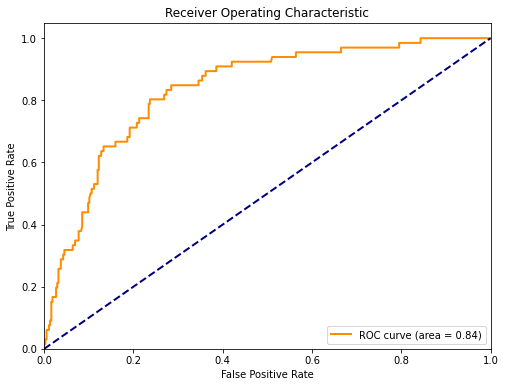

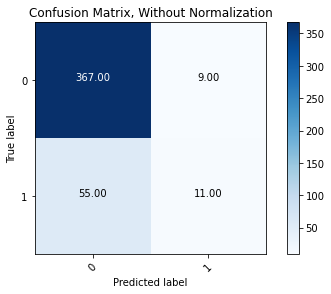

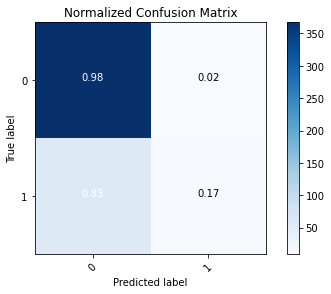

array([[367,   9],
       [ 55,  11]], dtype=int64)

In [11]:
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in test_data1.columns if col not in ['Education', 'Marital_Status', 'Response']]

test_scale = std_scale.transform(test_data1[numeric_cols])
test_encod = oh_encod.transform(test_data1[categorical_cols])

test_processed_data = np.hstack((test_scale, test_encod))
y_test = test_data1['Response']

# test 데이터 적용
model_auc = LogisticRegression(
    C=best_auc['C'],
    penalty=best_auc['penalty'],
    solver='saga',
    max_iter=best_auc['max_iter'],
    tol=best_auc['tol'],
    random_state=42
)
model_auc.fit(processed_data, y_train)
y_auc_pred = model_auc.predict(test_processed_data)
y_pred_proba = model_auc.predict_proba(test_processed_data)[:, 1]

f1 = f1_score(y_test, y_auc_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1-Score on Test Data: {f1}")
print(f"AUC on Test Data: {auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, model_auc.predict(test_processed_data))

def plot_conf_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['0', '1']

# 시각화 실행
plot_conf_matrix(cm, classes=class_names,
                 title='Confusion Matrix, Without Normalization')

# 정규화된 혼동 행렬 시각화도 가능
plt.figure()
plot_conf_matrix(cm, classes=class_names, normalize=True,
                 title='Normalized Confusion Matrix')

plt.show()
cm

F1-Score on Test Data: 0.0
AUC on Test Data: 0.5


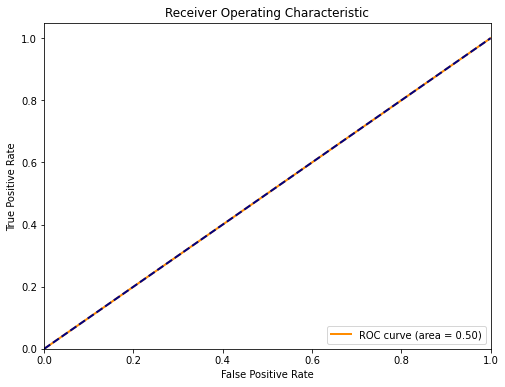

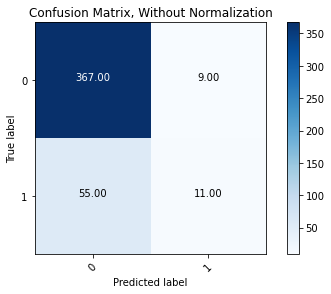

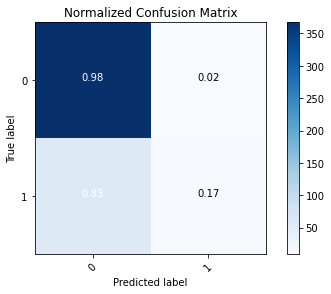

array([[367,   9],
       [ 55,  11]], dtype=int64)

In [12]:
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in train_data1.columns if col not in ['Education', 'Marital_Status', 'Response']]

test_scale = std_scale.transform(test_data1[numeric_cols])
test_encod = oh_encod.transform(test_data1[categorical_cols])

test_processed_data = np.hstack((test_scale, test_encod))
y_test = test_data1['Response']

# test 데이터 적용
model_f1 = LogisticRegression(
    C=best_f1['C'],
    penalty=best_f1['penalty'],
    solver=best_f1['solver'],
    max_iter=best_f1['max_iter'],
    tol=best_f1['tol'],
    random_state=42
)
model_f1.fit(processed_data, y_train)
y_auc_pred = model_f1.predict(test_processed_data)
y_pred_proba = model_f1.predict_proba(test_processed_data)[:, 1]

f1 = f1_score(y_test, y_auc_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1-Score on Test Data: {f1}")
print(f"AUC on Test Data: {auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, model_auc.predict(test_processed_data))

def plot_conf_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['0', '1']

# 시각화 실행
plot_conf_matrix(cm, classes=class_names,
                 title='Confusion Matrix, Without Normalization')

# 정규화된 혼동 행렬 시각화도 가능
plt.figure()
plot_conf_matrix(cm, classes=class_names, normalize=True,
                 title='Normalized Confusion Matrix')

plt.show()
cm

F1-Score on Test Data: 0.0
AUC on Test Data: 0.5


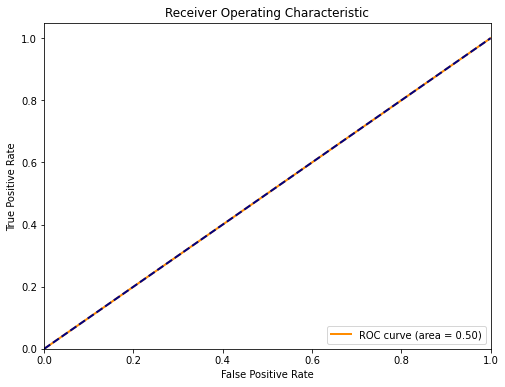

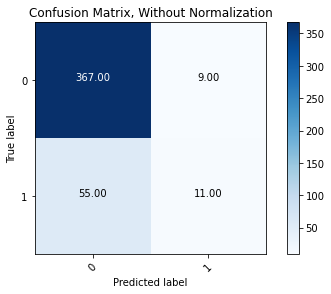

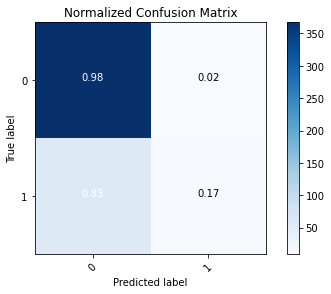

array([[367,   9],
       [ 55,  11]], dtype=int64)

In [13]:
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in train_data1.columns if col not in ['Education', 'Marital_Status', 'Response']]

test_scale = std_scale.transform(test_data1[numeric_cols])
test_encod = oh_encod.transform(test_data1[categorical_cols])

test_processed_data = np.hstack((test_scale, test_encod))
y_test = test_data1['Response']

# test 데이터 적용
model_all = LogisticRegression(
    C=best_all['C'],
    penalty=best_all['penalty'],
    solver=best_all['solver'],
    max_iter=best_all['max_iter'],
    tol=best_all['tol'],
    random_state=42
)
model_all.fit(processed_data, y_train)
y_auc_pred = model_all.predict(test_processed_data)
y_pred_proba = model_all.predict_proba(test_processed_data)[:, 1]

f1 = f1_score(y_test, y_auc_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1-Score on Test Data: {f1}")
print(f"AUC on Test Data: {auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, model_auc.predict(test_processed_data))

def plot_conf_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['0', '1']

# 시각화 실행
plot_conf_matrix(cm, classes=class_names,
                 title='Confusion Matrix, Without Normalization')

# 정규화된 혼동 행렬 시각화도 가능
plt.figure()
plot_conf_matrix(cm, classes=class_names, normalize=True,
                 title='Normalized Confusion Matrix')

plt.show()
cm